In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import shap

from main import Model
from utils import get_data, get_data_of_second_dataset, calculate_th

In [2]:
def experiment(data, target):
    X_train, X_test, y_train, y_test = train_test_split(data, target['ber'], test_size=0.20, random_state=75, stratify=target['class'])

    threshold = calculate_th(target[['class', 'ber']], 'ber')

    model = Model(th=threshold)
    model_1 = Model(th=threshold, include_original_features=True)
    model_2 = Model(th=threshold, include_original_features=True, include_prediction_interval=True)
    model_3 = Model(th=threshold, include_prediction_interval=True)

    model.fit(X_train, y_train)
    model_1.fit(X_train, y_train)
    model_2.fit(X_train, y_train)
    model_3.fit(X_train, y_train)

    y_pred, out = model.predict(X_test)
    y_pred_1, _ = model_1.predict(X_test)
    y_pred_2, _ = model_2.predict(X_test)
    y_pred_3, _ = model_3.predict(X_test)

    y_true = target.loc[y_test.index, 'class']

    model.evaluate_model_1(y_true.astype(int))

    print('[Model 2 evaluation]: [SHAP values]')
    model.evaluate_model_2(y_true)

    print('[Model 2 evaluation]: [SHAP values] [Input Data Features]')
    model_1.evaluate_model_2(y_true)

    print('[Model 2 evaluation]: [SHAP values] [Prediction Interval]')
    model_3.evaluate_model_2(y_true)

    print('[Model 2 evaluation]: [SHAP values] [Input Data Features] [Prediction Interval]')
    model_2.evaluate_model_2(y_true)

    print("[Base Model]: Regression + Classification")
    y_pred_base = (
            out['y_pred'] < threshold
    ).astype(int)
    print(confusion_matrix(y_true, y_pred_base))
    print(classification_report(y_true, y_pred_base, digits=4))

    print('[Pipeline]: [SHAP values]')
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))

    print('[Pipeline]: [SHAP values] [Input Data Features]')
    print(confusion_matrix(y_true, y_pred_1))
    print(classification_report(y_true, y_pred_1, digits=4))

    print('[Pipeline]: [SHAP values] [Prediction Interval]')
    print(confusion_matrix(y_true, y_pred_2))
    print(classification_report(y_true, y_pred_2, digits=4))

    print('[Pipeline]: [SHAP values] [Input Data Features] [Prediction Interval]')
    print(confusion_matrix(y_true, y_pred_3))
    print(classification_report(y_true, y_pred_3, digits=4))

    return out, X_test, y_test, model, y_true

In [3]:
out, X_test, y_test, model, y_true = experiment(*get_data())

[Model 1 evaluation]: 95.54% certain outcome, 4.462% uncertain outcome
[[ 68554     17]
 [    14 171198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68571
           1       1.00      1.00      1.00    171212

    accuracy                           1.00    239783
   macro avg       1.00      1.00      1.00    239783
weighted avg       1.00      1.00      1.00    239783

[Model 2 evaluation]: [SHAP values]
[[5040  743]
 [ 743 4674]]
              precision    recall  f1-score   support

         0.0     0.8715    0.8715    0.8715      5783
         1.0     0.8628    0.8628    0.8628      5417

    accuracy                         0.8673     11200
   macro avg     0.8672    0.8672    0.8672     11200
weighted avg     0.8673    0.8673    0.8673     11200

[Model 2 evaluation]: [SHAP values] [Input Data Features]
[[5155  628]
 [ 624 4793]]
              precision    recall  f1-score   support

         0.0     0.8920    0.8914    

In [5]:
y_true

sample
302905     1.0
30475      1.0
271214     1.0
568777     1.0
727608     0.0
          ... 
348031     1.0
201365     1.0
143862     0.0
791422     1.0
1317143    1.0
Name: class, Length: 250983, dtype: float64

In [6]:
out

,y_lower,y_upper,y_pred,is_uncertain,is_valid_prediction,class_pred,corrected_prediction
sample,,,,,,,
302905,0.000810,0.001103,0.000900,0,1,1,1
30475,0.000181,0.000393,0.000319,0,1,1,1
271214,0.000390,0.000596,0.000475,0,1,1,1
568777,0.000519,0.000724,0.000568,0,1,1,1
727608,0.004288,0.005603,0.005180,0,1,0,0
...,...,...,...,...,...,...,...
348031,0.000257,0.000353,0.000340,0,1,1,1
201365,0.000445,0.000598,0.000584,0,1,1,1
143862,0.011028,0.013432,0.012201,0,1,0,0


In [18]:
y_certain = out[out['is_uncertain'] == 0]
y_uncertain = out[out['is_uncertain'] == 1]

y_true_certain = y_true[y_true.index.isin(y_certain.index)].astype(int)
y_true_uncertain = y_true[y_true.index.isin(y_uncertain.index)].astype(int)

x_uncertain = X_test[X_test.index.isin(y_uncertain.index)]
x_certain_true_pred = X_test[X_test.index.isin(y_certain[y_certain['class_pred'] == y_true_certain].index)]
x_certain_false_pred = X_test[X_test.index.isin(y_certain[y_certain['class_pred'] != y_true_certain].index)]

x_uncertain_true_pred = X_test[X_test.index.isin(y_uncertain[y_uncertain['class_pred'] == y_true_uncertain].index)]
x_uncertain_false_pred = X_test[X_test.index.isin(y_uncertain[y_uncertain['class_pred'] != y_true_uncertain].index)]

In [22]:
print(f'uncertain {len(x_uncertain)}')
print(f'certain & true predicted {len(x_certain_true_pred)}')
print(f'certain & false predicted {len(x_certain_false_pred)}')
print(f'uncertain: {len(x_uncertain_true_pred) / (len(x_certain_true_pred) + len(y_true_uncertain))* 100:.02f}, {len(x_uncertain_false_pred) /  (len(x_certain_false_pred) + len(x_uncertain_false_pred)) * 100:.02f}')

uncertain 11200
certain & true predicted 239752
certain & false predicted 31
uncertain: 3.56, 98.66


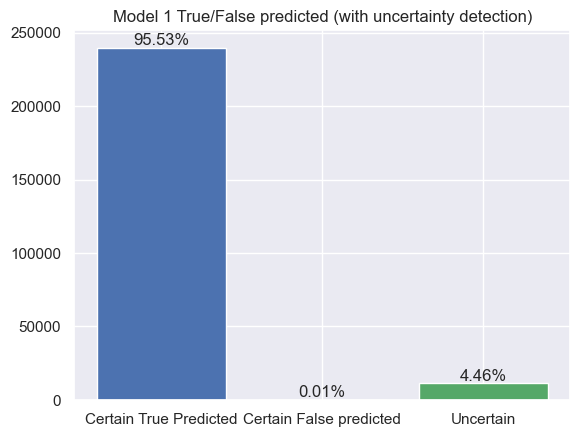

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

fig = plt.figure()
plt.title("Model 1 True/False predicted (with uncertainty detection)")
plt.xticks([0, 1, 2], ["Certain True Predicted", "Certain False predicted", "Uncertain"])
bar1 = plt.bar([0], [len(x_certain_true_pred)])
bar2 = plt.bar([1], [len(x_certain_false_pred)])
bar3 = plt.bar([2], [len(x_uncertain)])

for rect in bar1 + bar2 + bar3:
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2.0,
        height,
        f'{height / len(y_test) * 100:.02f}%',
        ha='center',
        va='bottom'
    )

plt.show()


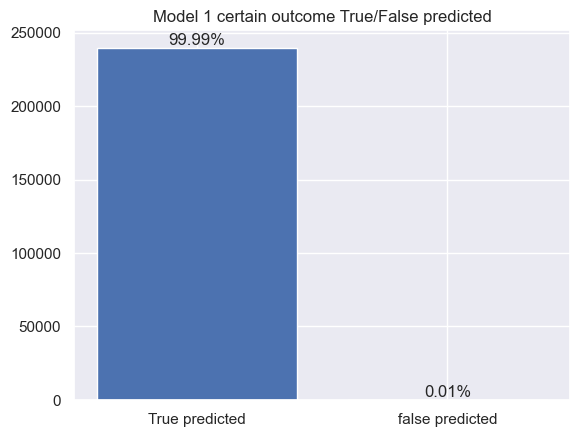

In [7]:
fig = plt.figure()
plt.title("Model 1 certain outcome True/False predicted")
plt.xticks([0, 1], ["True predicted", "false predicted"])
bar1 = plt.bar([0], [len(x_certain_true_pred)])
bar2 = plt.bar([1], [len(x_certain_false_pred)])

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2.0,
        height,
        f'{height / len(y_true_certain) * 100:.02f}%',
        ha='center',
        va='bottom'
    )

plt.show()


In [8]:
x_base_true_pred = X_test[X_test.index.isin(out[out['class_pred'] == y_true].index)]
x_base_false_pred = X_test[X_test.index.isin(out[out['class_pred'] != y_true].index)]
print(f'base model true predicted {len(x_base_true_pred)}')
print(f'base model false predicted {len(x_base_false_pred)}')

base model true predicted 248674
base model false predicted 2309


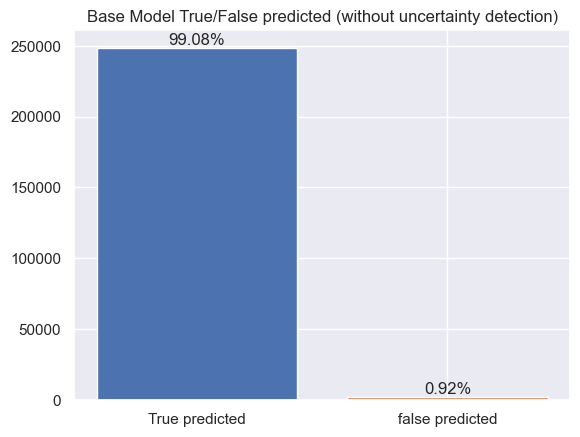

In [9]:
fig = plt.figure()
plt.title("Base Model True/False predicted (without uncertainty detection)")
plt.xticks([0, 1], ["True predicted", "false predicted"])
bar1 = plt.bar([0], [len(x_base_true_pred)])
bar2 = plt.bar([1], [len(x_base_false_pred)])

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2.0,
        height,
        f'{height / len(y_test) * 100:.02f}%',
        ha='center',
        va='bottom'
    )

plt.show()


uncertain


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


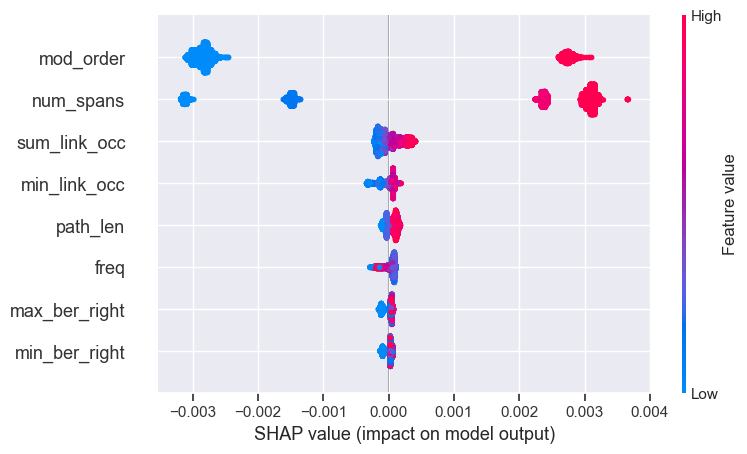

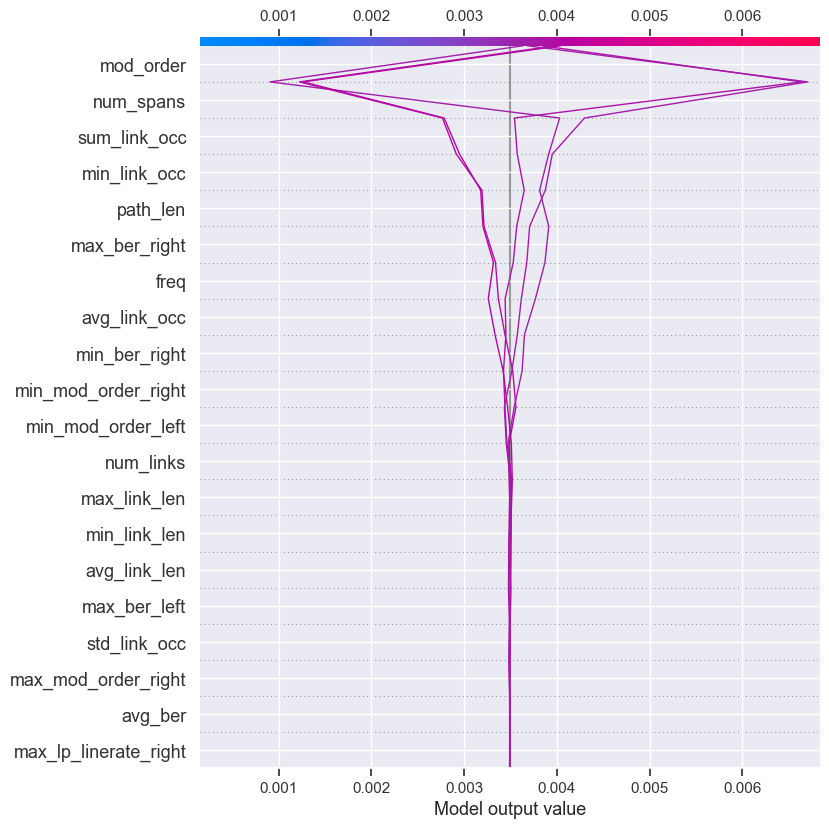

certain true prediction


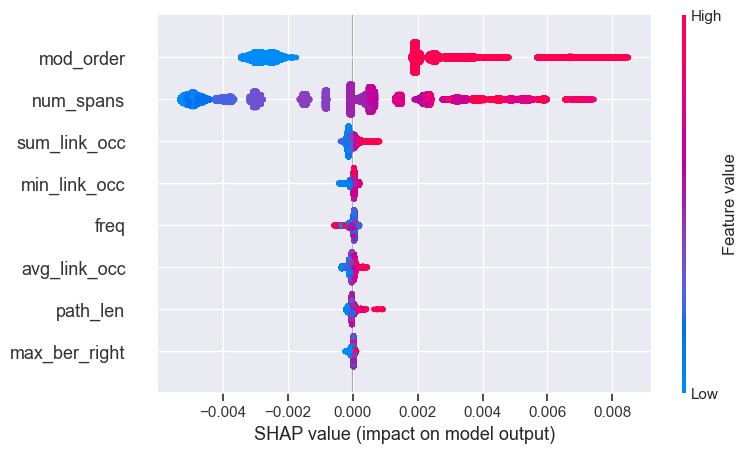

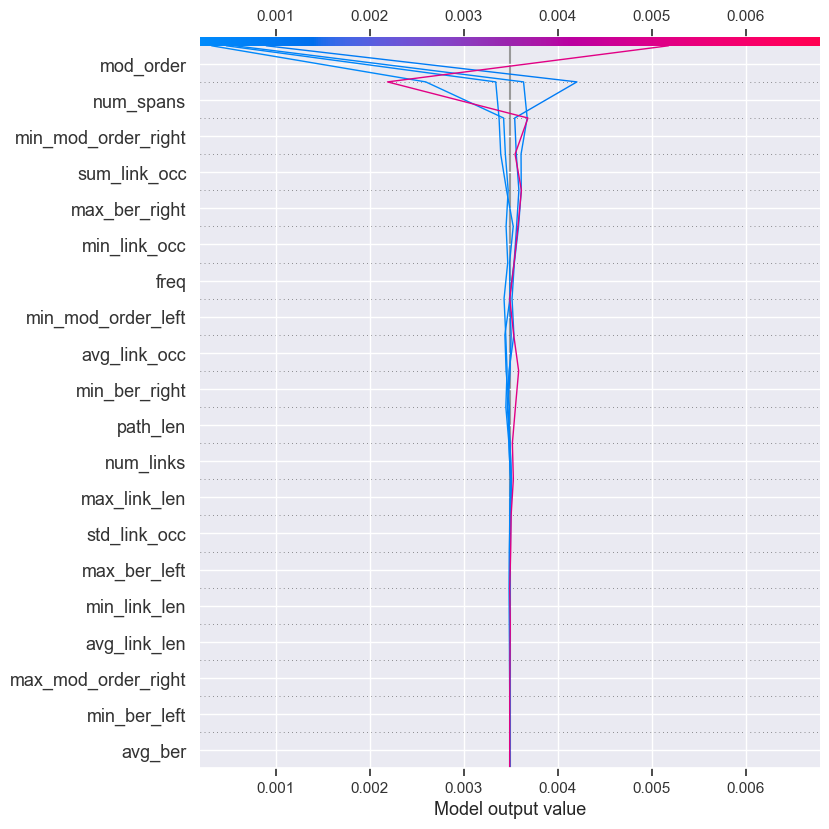

certain false prediction


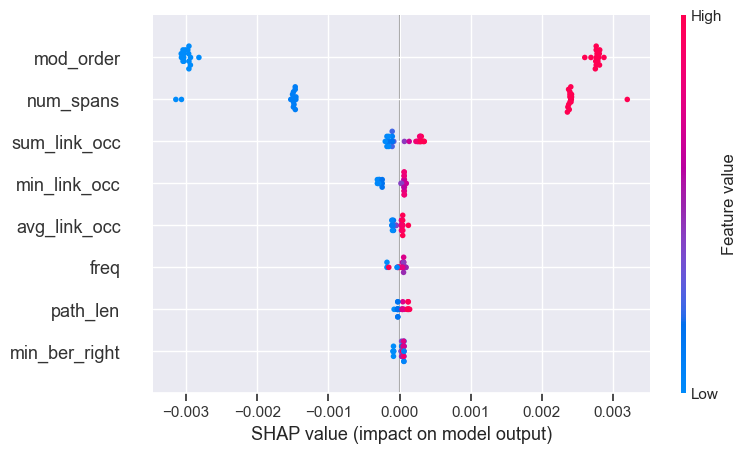

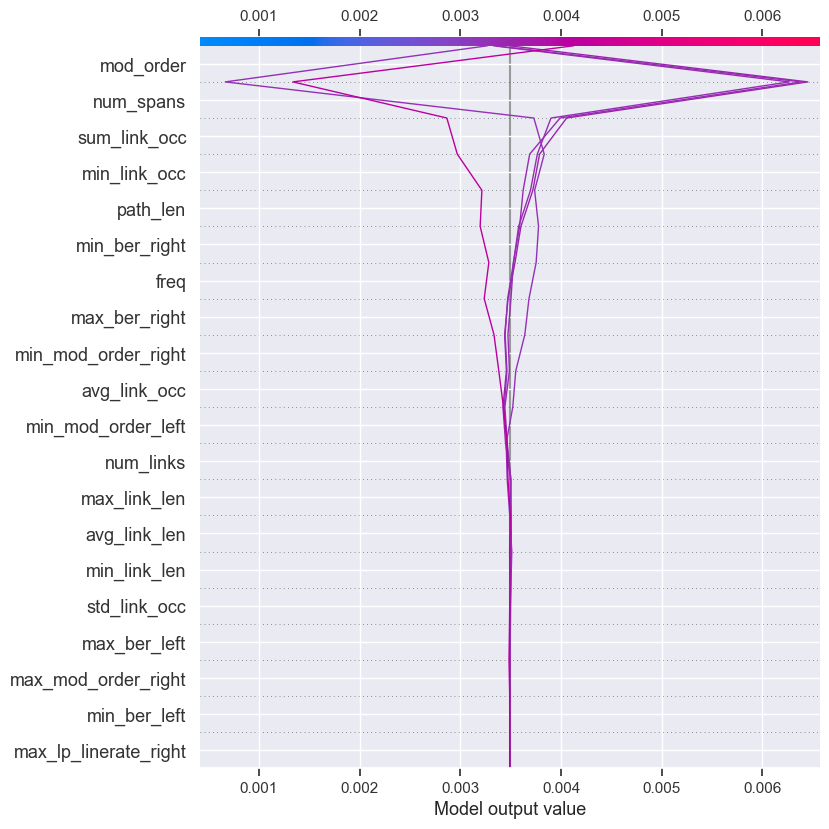

In [27]:
outcome_hash = {
    key: (model.explainer_classifier.shape_values(x), x, model.explainer_classifier.explainer.expected_value)
    for key, x in zip(
        ['uncertain', 'certain true prediction', 'certain false prediction'],
        [x_uncertain, x_certain_true_pred, x_certain_false_pred]
    )
}

for key, value in outcome_hash.items():
    print(key)
    shap_values, features, expected_value = value
    shap.summary_plot(shap_values, features, title=key, max_display=8)
    shap.decision_plot(expected_value[0], shap_values[:5], features[:5])

In [30]:
def clustering_experiment(shap_values, labels):
    import pandas as pd
    import seaborn as sns
    from umap import UMAP

    # compute 2D embedding of SHAP values
    cl = UMAP(
      n_components=2, n_neighbors=200, min_dist=0
    ).fit_transform(shap_values)

    sns.scatterplot(pd.DataFrame({'0': cl[:, 0], '1': cl[:, 1], 'class': labels}), x='0', y='1', hue='class')

uncertain


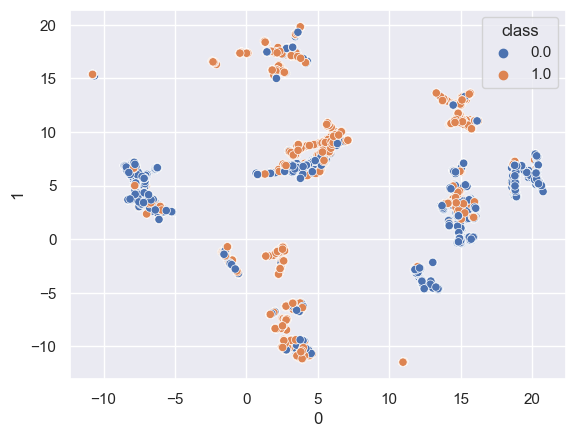

certain true prediction


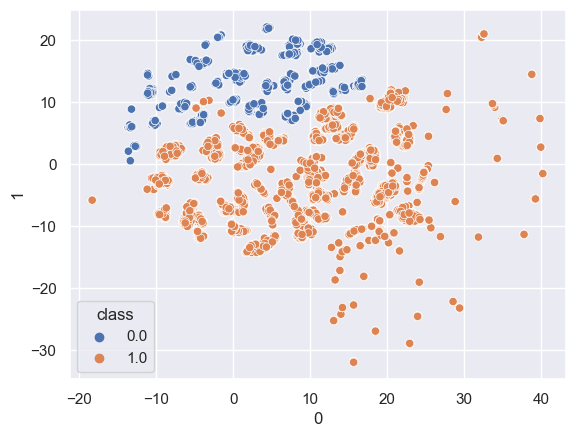

certain false prediction


n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1


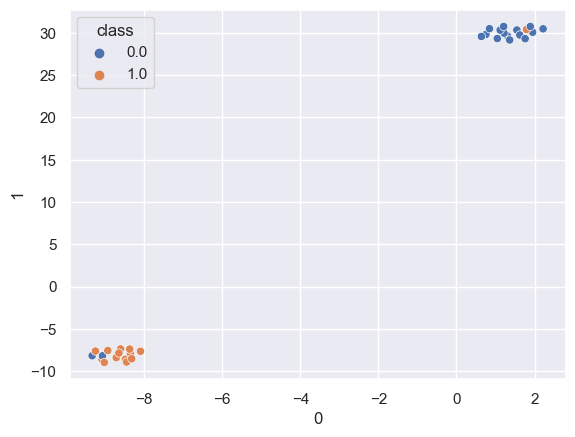

In [31]:
import matplotlib.pyplot as plt

for key, value in outcome_hash.items():
    print(key)
    shap_values, features, _ = value
    clustering_experiment(shap_values, y_true[y_true.index.isin(features.index)])
    plt.show()

In [12]:
experiment(*get_data_of_second_dataset())

[Model 1 evaluation]: 92.95% certain outcome, 7.048% uncertain outcome
int32 int64
[[     0     10]
 [     0 250644]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       1.00      1.00      1.00    250644

    accuracy                           1.00    250654
   macro avg       0.50      0.50      0.50    250654
weighted avg       1.00      1.00      1.00    250654

[Model 2 evaluation]: [SHAP values]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


[[16662   362]
 [  307  1674]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     17024
         1.0       0.82      0.85      0.83      1981

    accuracy                           0.96     19005
   macro avg       0.90      0.91      0.91     19005
weighted avg       0.97      0.96      0.97     19005

[Model 2 evaluation]: [SHAP values] [Input Data Features]
[[16717   307]
 [  266  1715]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     17024
         1.0       0.85      0.87      0.86      1981

    accuracy                           0.97     19005
   macro avg       0.92      0.92      0.92     19005
weighted avg       0.97      0.97      0.97     19005

[Model 2 evaluation]: [SHAP values] [Prediction Interval]
[[16662   362]
 [  307  1674]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     17024
         1.0       0.82     